In [1]:
%matplotlib notebook

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn
from scipy.interpolate import interp1d

In [2]:
micro_data = pd.read_pickle('../divestdata/P3/micro/unified_trajectory')['mean_trajectory']
macro_data = pd.read_pickle('../divestdata/P3/aggregate/unified_trajectory')['mean_trajectory']
rep_data = pd.read_pickle('../divestdata/P3/res/unified_trajectory')['mean_trajectory']

In [3]:
def l_2_distance(d1, d2, observable=None):
    
    d1_data = d1.unstack('observables')[[observable]]
    d2_data = d2.unstack('observables')[[observable]]
    
    names = d1.index.names
    print(names)
    indices = {ax: list(d1.index.levels[names.index(ax)].values) for ax in names[:2]}
    print(indices)
    output = np.zeros((len(indices[names[0]]),len(indices[names[1]])))
    
    for i, n0 in enumerate(indices[names[0]]):
        for j, n1 in enumerate(indices[names[1]]):
            levels = names[:2]
            tkey = [n0, n1]
    
            # get values and times from dataframes
            d1_slice = d1_data.xs(key=tkey, level=levels).values.T[0][:-1]
            d1_times = d1_data.xs(key=tkey, level=levels).index.values[:-1]

            d2_slice = d2_data.xs(key=tkey, level=levels).values.T[0][:-1]
            d2_times = d2_data.xs(key=tkey, level=levels).index.values[:-1]
            
            # interpolate to get values on equal timepoints
            d1_ipl = interp1d(d1_times, d1_slice)
            d2_ipl = interp1d(d2_times, d2_slice)

            samples = 200
            times = np.linspace(d1_times[0], d1_times[-1], samples)
            d1_ipl_data = d1_ipl(times)
            d2_ipl_data = d2_ipl(times)
            dd = d1_ipl_data - d2_ipl_data
            l2 = sum(dd*dd)
            output[i, j] = l2
            
    return output, indices, names[:2]

In [4]:
levels=['b_d', 'eps']
key=[1.25, 0.05]

data, indices, ax_names = l_2_distance(micro_data.xs(key=key, level=levels), macro_data.xs(key=key, level=levels), observable='n_c')

['phi', 'tau', 'timesteps', 'observables']
{'phi': [0.0, 0.10000000000000001, 0.20000000000000001, 0.29999999999999999, 0.40000000000000002, 0.5, 0.59999999999999998, 0.69999999999999996, 0.80000000000000004, 0.90000000000000002, 1.0], 'tau': [0.10000000000000001, 0.31622776601683794, 1.0, 3.1622776601683795, 10.0, 31.622776601683793, 100.0, 316.22776601683796, 1000.0]}


<IPython.core.display.Javascript object>


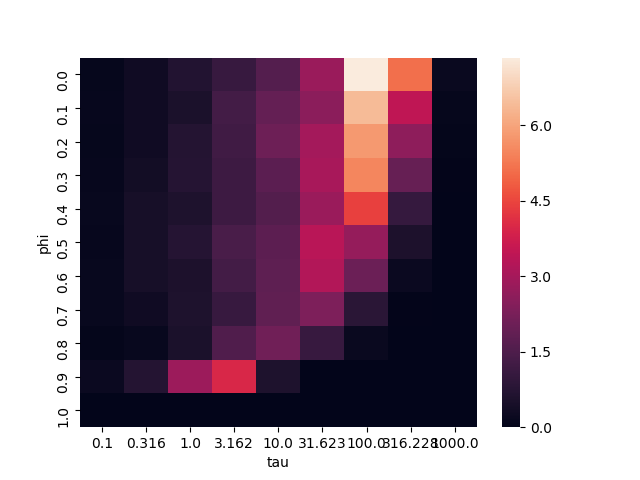

In [5]:
ax = seaborn.heatmap(data,
                yticklabels=indices[ax_names[0]], 
                xticklabels=[round(x, 3) for x in indices[ax_names[1]]])
ax.set_ylabel(ax_names[0])
ax.set_xlabel(ax_names[1])